# Objetivo do trabalho e definição do problema

O objetivo deste trabalho é apresentar métodos para análise de concessão de crédito. Neste sentido, serão utilizadas técnicas que permitam classificar determinada pessoa como boa pagadora o má pagadora, sem necessidade de interpretar quais variáveis são mais importantes na definição da classe. 

Para tornar o estudo um pouco mais factível, irei atribuir pesos a cada tipo de erro. Neste caso, será considerado que o custo de se conceder crédito a um mau pagador é de R$500, enquanto que o lucro de se emprestar dinheiro a um bom pagador é de proximadamente R$10 reais. Não há ganho ou perda em se negar crédito a alguém.

# Estrutura do trabalho

A primeira etapa é fazer o tratamento dos dados. Como mostrado, há observações com valores faltantes e valores absurdos que devem ser tratados para permitir uma melhor modelagem dos dados. Concomitantemente, é feita uma breve análise exploratória dos dados.

Após isso, deve ser aplicar os métodos de Machine Learning que cumpram com os objetivos citados.

Por fim, será possível extrair conclusões sobre os métodos, e definir quais modelos melhor funcionaram.

# Sobre os dados

Os dados foram retirados da competição disponível em https://www.kaggle.com/competitions/GiveMeSomeCredit/data , mas utilizarei apenas o dados que foram colocados como de treino, e os repartirei entre treino e teste. A razão para isso é que os dados disponíveis para teste não possuem a identificação de categoria na variável de interesse para este trabalho. 

Partirei do pressuposto que essa é uma amostra aleatória, sem medidas repetidas ou altamente correlacionadas (como as oriundas de uma amostragem por conglomerados, por exemplo).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
dados = pd.read_csv("cs-training.csv")
dados.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Tem uma coluna chamada Unnamed: 0 que é apenas um index. Podemos confirmar isso com o código a seguir

In [ ]:
(dados.index + 1 == dados["Unnamed: 0"]).all()

True

Portanto, devemos remover essa coluna dos dados.

In [ ]:
dados = dados.drop(['Unnamed: 0'], axis = 1)

In [ ]:
dados.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Conforme explicado no arquivo "Data Dictionary.xls", temos as colunas aqui especificadas. Em resumo, a variável de interesse é a "SeriousDlqin2yrs" que diz se a pessoa é severamente má pagadora ou não. Nos dados são 10026 maus pagadores e 139974 bons pagadores, indicando um claro, e já esperado, desbalanceamento nos dados. São 150000 observações e 11 variáveis.

In [ ]:
print(pd.value_counts(dados["SeriousDlqin2yrs"]))
print(dados.shape)

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64
(150000, 11)


C:\Users\lucas\AppData\Local\Temp\ipykernel_15248\1751075710.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(dados["SeriousDlqin2yrs"]))


Entendendo um pouco mais do conjunto, devemos também remover possíveis observações duplicadas, que, pela natureza das variáveis, não é possível de ocorrer. Conforme vemos abaixo, temos observações duplicadas.

In [ ]:
dados.duplicated().any()

True

In [ ]:
dados = dados.drop_duplicates()

Resolvido! Vamos conferir agora a quantidade de observações faltantes

In [ ]:
dados.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64

29221 observações não possuem informação sobre o recebimento mensal, e 3828 sobre o número de dependentes. Vamos verificar se essa ausência de informação está relacionada à variável resposta ou não

In [ ]:
dados[dados.NumberOfDependents.isnull()].SeriousDlqin2yrs.sum()/dados[dados.NumberOfDependents.isnull()].shape[0]

0.04649947753396029

Aproximadamente 4.65% dos dados sem numéro de dependentes é mau pagador. Repare que é uma proporção similar à encontrada nos dados originais (6.7%). Portanto, as removerei sem grandes perdas. O mesmo vale para a coluna "MonthlyIncome", com proporção de 5.66%. Logo, a variável resposta não parece estar ligada à ausência de informação nessas variáveis, concluindo, então, que podemos excluir essas observações.

Essa é uma boa ideia para se manter em mente. Contudo, será nossa última opção, já que leva à perda de informação. Primeiro, vamos tentar encontrar correlação entre a ausência de dados e outra informação que nós temos.

Podemos reparar que todas as observações sem número de dependentes computado também não possuem o rendimento mensal

In [ ]:
dados[dados.NumberOfDependents.isnull()].describe().round(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,3828.00,3828.00,3828.00,3828.00,3828.00,0.0,3828.00,3828.00,3828.00,3828.00,0.0
mean,0.05,11.00,59.74,0.57,1110.71,NaN,5.71,0.50,0.61,0.47,NaN
std,0.21,240.66,18.35,6.53,4235.41,NaN,4.09,6.52,0.92,6.52,NaN
min,0.00,0.00,21.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,NaN
25%,0.00,0.01,48.00,0.00,25.00,NaN,3.00,0.00,0.00,0.00,NaN
50%,0.00,0.05,61.00,0.00,398.00,NaN,5.00,0.00,0.00,0.00,NaN
75%,0.00,0.26,74.00,0.00,1587.00,NaN,8.00,0.00,1.00,0.00,NaN
max,1.00,10821.00,109.00,98.00,220516.00,NaN,30.00,98.00,15.00,98.00,NaN


C:\Users\lucas\AppData\Local\Temp\ipykernel_15248\3097820870.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plt.bar(pd.value_counts(dados['NumberOfDependents']).index, pd.value_counts(dados['NumberOfDependents']).values)


<BarContainer object of 13 artists>

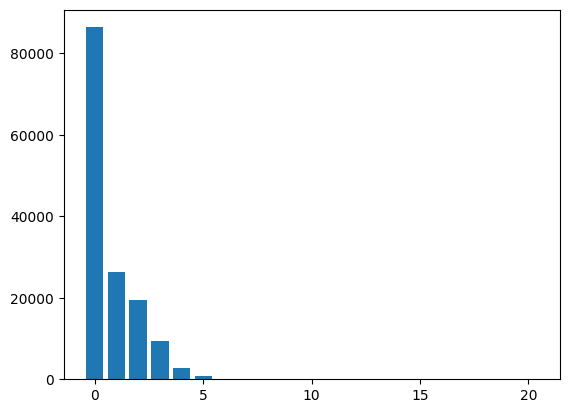

In [ ]:
plt.bar(pd.value_counts(dados['NumberOfDependents']).index, pd.value_counts(dados['NumberOfDependents']).values)

A categoria mais comum é, disparado, a com 0 dependentes. Dessa forma, podemos imputar esse valor aos dados faltantes sem grandes perdas.

In [ ]:
dados[dados['NumberOfDependents'].isna()]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
8,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
96,0,0.542243,48,2,10.0,NaN,2,0,0,0,NaN
109,0,0.041258,61,0,4739.0,NaN,11,0,4,0,NaN
159,0,0.000000,63,0,2.0,NaN,4,0,0,0,NaN
238,0,1.000000,28,0,0.0,NaN,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
149826,0,0.027319,71,0,1419.0,NaN,13,0,1,0,NaN
149854,0,0.056589,75,0,8.0,NaN,3,0,0,0,NaN
149894,0,0.017904,55,0,1058.0,NaN,8,0,1,1,NaN
149948,0,0.055530,27,0,10.0,NaN,1,0,0,0,NaN


C:\Users\lucas\AppData\Local\Temp\ipykernel_15248\3097820870.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plt.bar(pd.value_counts(dados['NumberOfDependents']).index, pd.value_counts(dados['NumberOfDependents']).values)


<BarContainer object of 13 artists>

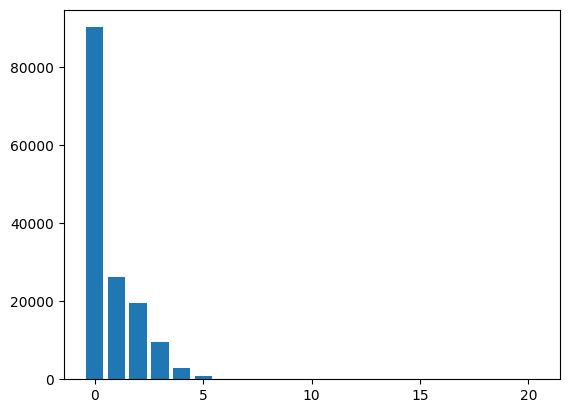

In [ ]:
dados['NumberOfDependents'] = dados['NumberOfDependents'].fillna(0)
plt.bar(pd.value_counts(dados['NumberOfDependents']).index, pd.value_counts(dados['NumberOfDependents']).values)

Interessante notar que o gráfico de barras não foi modificado radicalmente, um bom sinal de que não estamos modificando a natureza dos dados. Uma vez que corrigimos os valores faltantes do número de dependentes, vamos corrigir os de rendimento mensal. Primeramente, vamos corrigir apenas as observações que foram corrigidas para a outra variável. Repare que as duas variáveis estão relacionadas, isto é, quanto maior a quantidade de dependentes, maior costuma ser os rendimentos.

<Axes: xlabel='NumberOfDependents'>

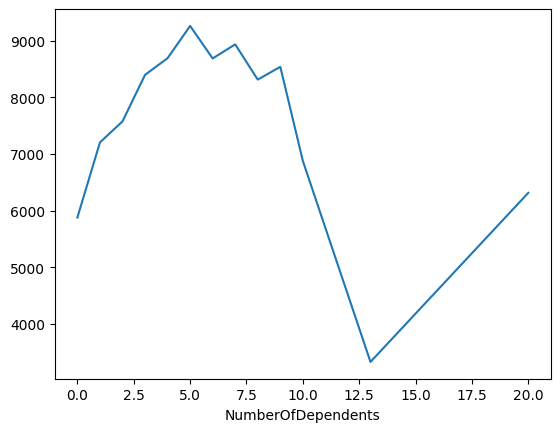

In [ ]:
dados.groupby('NumberOfDependents')['MonthlyIncome'].mean().plot()

E essa é a distribuição do MonthlyIncome, com o gráfico truncado em 30000 pois os outliers atrapalhariam muito a visualização dos dados.

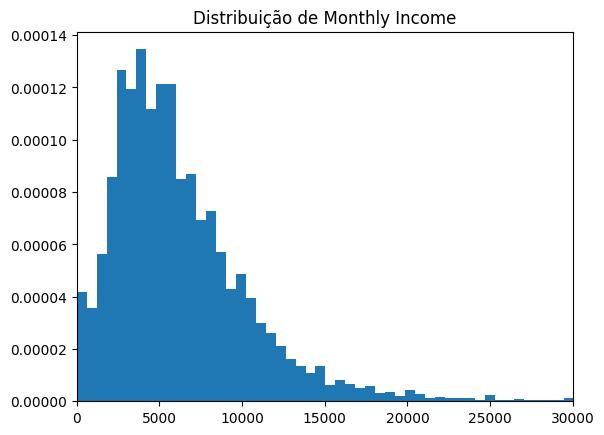

In [ ]:
plt.hist(dados['MonthlyIncome'], bins = 5000, density=True)
plt.xlim(0, 30000)  # Ajusta o range do eixo X
plt.title('Distribuição de Monthly Income')
plt.show()

Vamos atribuir às observações faltantes de MonthlyIncome a média dessa mesma variável dado o número de dependentes. Importante notar que a grande maioria dos dados estão ligados àquelas cuja observação de número de dependentes é zero, e o maior valor é 9, então não teremos grandes problemas de atribuir a média de valores muito raros (como por exemplo com 20 dependentes).

In [ ]:
dados['MonthlyIncome'].fillna(
    dados.groupby('NumberOfDependents')['MonthlyIncome'].transform('mean')
)

0          9120.000000
1          2600.000000
2          3042.000000
3          3300.000000
4         63588.000000
              ...     
149995     2100.000000
149996     5584.000000
149997     5881.171749
149998     5716.000000
149999     8158.000000
Name: MonthlyIncome, Length: 149391, dtype: float64

In [ ]:
dados['MonthlyIncome'] = dados['MonthlyIncome'].fillna(
    dados.groupby('NumberOfDependents')['MonthlyIncome'].transform('mean')[dados['MonthlyIncome'].isnull()]
)

Repare que a distribuição dos dados modificou mais do que a do número de dependentes, até mesmo por conta da quantidade de observações imputadas, mas a natureza da distribuição segue a mesma.

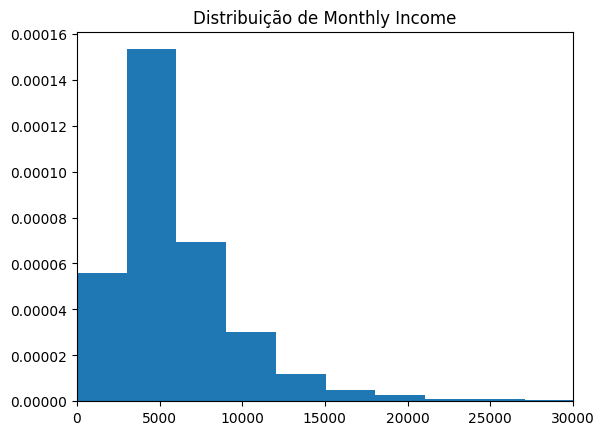

In [ ]:
plt.hist(dados['MonthlyIncome'], bins = 1000, density=True)
plt.xlim(0, 30000)  # Ajusta o range do eixo X
plt.title('Distribuição de Monthly Income')
plt.show()

Agora estamos sem observações faltantes (conforme mostrado abaixo), e podemos, portanto, partir para a análise exploratória dos dados em busca de observações atípicas. Isso terá como objetivo a verificação da qualidade dos dados.

In [ ]:
dados.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [ ]:
dados[dados.NumberOfDependents.isnull()].shape

(0, 11)

Antes, podemos verificar que há algo estranho nos dados de RevolvingUtilizationOfUnsecuredLines. Repare que esses valores deveriam estar entre 0 e 1, mas há alguns valores fora desse intervalo, conforme visto abaixo

In [ ]:
dados[dados['RevolvingUtilizationOfUnsecuredLines'] > 5].shape

(254, 11)

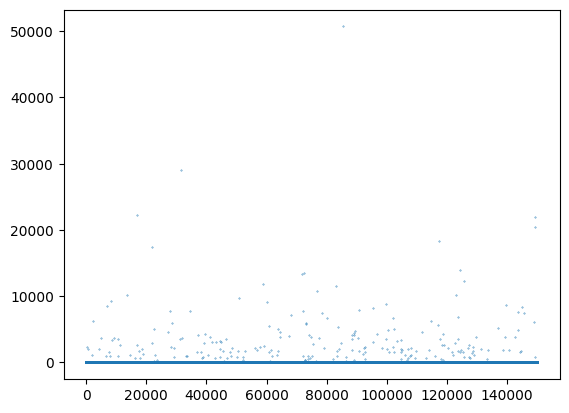

In [ ]:
plt.scatter(dados['RevolvingUtilizationOfUnsecuredLines'].index, dados['RevolvingUtilizationOfUnsecuredLines'].values, s=.1)

In [ ]:
dados[dados['RevolvingUtilizationOfUnsecuredLines'] > 5].groupby('SeriousDlqin2yrs').size()

SeriousDlqin2yrs
0    234
1     20
dtype: int64

A proporção de bons pagadores para maus pagadores (7.8%) é parecida com as dos dados originais (6.7%), então podemos remover essas observações fora do padrão sem desequilibrar ainda mais o conjunto de dados.

In [ ]:
dados = dados.drop(dados[dados['RevolvingUtilizationOfUnsecuredLines'] > 5].index)

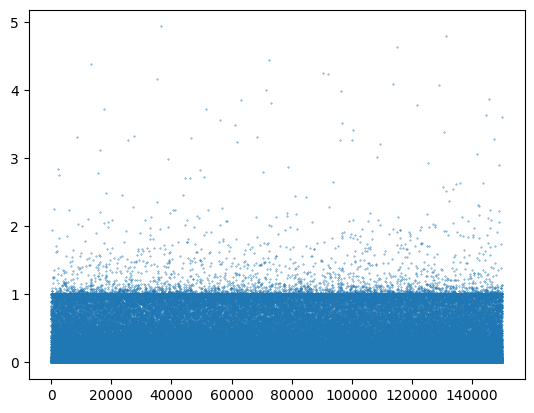

In [ ]:
plt.scatter(dados['RevolvingUtilizationOfUnsecuredLines'].index, dados['RevolvingUtilizationOfUnsecuredLines'].values, s=.1)

(array([1.0000e+00, 1.6200e+02, 1.4431e+04, 2.9547e+04, 3.9960e+04,
        3.6674e+04, 1.9533e+04, 7.5760e+03, 1.2320e+03, 2.1000e+01]),
 array([  0. ,  10.9,  21.8,  32.7,  43.6,  54.5,  65.4,  76.3,  87.2,
         98.1, 109. ]),
 <BarContainer object of 10 artists>)

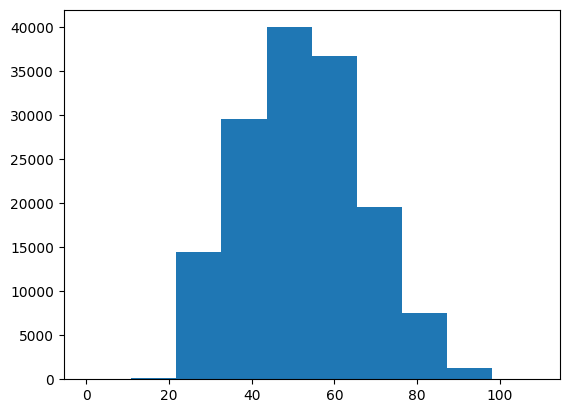

In [ ]:
plt.hist(dados['age'])

In [ ]:
dados['age'].describe()

count    149137.000000
mean         52.309762
std          14.725763
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

Alguns vaores muito altos (acima de 100 anos de idade), mas, por falta de informações adicionais, deixarei eles presentes no conjunto de dados

In [ ]:
dados.groupby(['NumberOfTime30-59DaysPastDueNotWorse']).size()

NumberOfTime30-59DaysPastDueNotWorse
0     125229
1      16020
2       4586
3       1750
4        746
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       220
dtype: int64

Que estranho! Os dados iam aumentando de um em um, até um salto de 13 para 96. Por falta de maior entendimento dos dados, poderiamos aceitar isso, visto que temos poucas observações a partir do 10, mas o salto de 13 para 96 é injustificável. Essas observações devem ser removidas. O problema, contudo, é que esses valores anormais são relacionados com a variável resposta, isto é, mais da metade deles valem 1 na variável 'SeriousDlqin2yrs'. Dessa forma, vamos tentar apenas amenizar o problema. Vamos transformar esses valores absurdamente grandes em valores razoavelmente grandes.

In [ ]:
dados.loc[dados['NumberOfTime30-59DaysPastDueNotWorse'] > 7, 'NumberOfTime30-59DaysPastDueNotWorse'] = 7

In [ ]:
dados.groupby(['NumberOfTime30-59DaysPastDueNotWorse']).size()

NumberOfTime30-59DaysPastDueNotWorse
0    125229
1     16020
2      4586
3      1750
4       746
5       342
6       140
7       324
dtype: int64

Outro problema é na variável 'DebtRatio'. Repare que há algumas observações muito fora do razoável. Por exemplo, o valor máximo do conjunto. Nele, a relação entre custos mensais e recebimentos mensais é de 329664 vezes. Ou seja, essa pessoa 'gasta' 329664 vezes mais do que recebe. Isso é um valor irreal e que influenciará muito nos modelos gerados. Com base nos quantis, vemos o seguinte:

In [ ]:
dados['DebtRatio'].quantile(.98)

3841.0

In [ ]:
dados[dados['DebtRatio'] > 3841]['DebtRatio'].describe()

count      2980.000000
mean       6490.371812
std       12186.220461
min        3842.000000
25%        4298.750000
50%        4984.500000
75%        6189.500000
max      329664.000000
Name: DebtRatio, dtype: float64

Que curioso! Um salto enorme do quantil 75% para o máximo. Claro, em um contexto real isso deveria ser discutido com a equipe, mas como estou apenas estudando por conta própria, irei apenas remover essas observações se não desbalancear os grupos ainda mais.

In [ ]:
dados[dados['DebtRatio'] > 3841][['DebtRatio', 'SeriousDlqin2yrs']].groupby('SeriousDlqin2yrs').describe()

DebtRatio                                              \
                     count         mean           std     min      25%   
SeriousDlqin2yrs                                                         
0                   2780.0  6491.541187  12560.360852  3842.0  4299.00   
1                    200.0  6474.117500   4466.976577  3844.0  4261.75   

                                             
                     50%      75%       max  
SeriousDlqin2yrs                             
0                 4973.5  6167.25  329664.0  
1                 5226.0  6628.25   38793.0

Ótimo! A remoção não impacta no balanceamento dos grupos.

In [ ]:
dados = dados[dados['DebtRatio'] <= 3841]

In [ ]:
dados.shape

(146157, 11)

Restaram então 146157 observações! Podemos notar que a proporção de zeros e uns na variável de interesse segue parecida.

In [ ]:
print(pd.value_counts(dados["SeriousDlqin2yrs"])/dados.shape[0])

SeriousDlqin2yrs
0    0.933024
1    0.066976
Name: count, dtype: float64


C:\Users\lucas\AppData\Local\Temp\ipykernel_15248\1399983098.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(dados["SeriousDlqin2yrs"])/dados.shape[0])


# Modelagem dos dados

Primeiro, devemos separar os dados entre treino e teste, tendo a garantia de que a variável resposta está sendo tratada como categórica

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

dados['SeriousDlqin2yrs'] = dados['SeriousDlqin2yrs'].astype('category')
x = dados.drop(['SeriousDlqin2yrs'], axis=1).values
y = dados['SeriousDlqin2yrs'].values
x = dados.iloc[:, 1:]
y = dados.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
import sklearn
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Vamos usar algumas modelagens comuns nesse contexto.

## XGBoost

### Sem seleção dos hiperparâmetros

Primeiro, vamos avaliar uma modelagem básica, isto é, sem ajuste dos hiperparâmetros. Essa modelagem é feita apenas para exemplificar como o processo funcionará. Além disso, é de grande ajuda para demonstrar a razão da escolha de alguns hiperparâmetros.

In [ ]:
modelo_xgb = XGBClassifier(tree_method = 'exact')
modelo_xgb.fit(X_train, y_train)
y_pred = modelo_xgb.predict(X_test)

Vamos verificar a acuracidade do modelo.

In [ ]:
accuracy_score(y_test, y_pred)

0.9358921729611385

Um valor próximo de 1. Contudo, não é de se impressionar, uma vez que o conjunto de dados é extremamente desbalanceado.

In [ ]:
confusion_matrix(y_test, y_pred)

array([[26958,   316],
       [ 1558,   400]], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27274
           1       0.56      0.20      0.30      1958

    accuracy                           0.94     29232
   macro avg       0.75      0.60      0.63     29232
weighted avg       0.92      0.94      0.92     29232



Ou seja, 95% dos indivíduos que foram classificados como bons pagadores (0), eram de fato bons pagadores. Ao mesmo tempo, 99% das pessoas que eram classificadas como boas pagadores foram classificadas dessa maneira.
56% das pessoas que eu classifiquei como más pagadoras, eram de fato más pagadoras. O valor mais alto aqui indicaria que eu só classifico como más as pessoas que realmente não vão pagar. É um complemento à metrica anterior para dizer se estou perdendo bons clientes ou não. Por fim, 20% das pessoas más pagadoras foram corretamente identificadas. Essa métrica deveria estar muito melhor, para assim não correr o risco de emprestar dinheiro às pessoas que não pagarão de volta.

Em outras palavras:

5% das pessoas você falou que era boas pagadoras mas deram calote. Esse valor talvez seja muito alto. Qual o custo desses calotes? Gostaria de reduzir mais esse número, mesmo que ao custo do aumento do próximo.
1% das pessoas que poderiam ter pego emprestimo porque iriam me pagar, não receberam o crédito. Estou perdendo esses clientes que me dariam lucro.

56% das pessoas que eu disse que eram más pagadoras, eram, de fato, caloteiras. Isso indica que eu não estou indiscriminadamente classificando as pessoas como más pagadoras. Ainda sim, gostaria de aumentar esse número, assim eu não perderia clientes desnecessasriamente. Contudo, a próxima métrica é mais importante.
20% das pessoas caloteiras foram identificadas dessa maneira. Isso escancara o quão ruim esse modelo foi. Na realidade, gostariamos que esse valor aumentasse o máximo possível, mesmo que a custa de piorar as demais métricas. Aqui, o problema é mais grave que nos demais casos, pois estamos emprestando dinheiro para gente que não vai pagar de volta. Nas outras situações, o máximo que estava acontecendo era deixar de captar bons clientes.


Com mais casas decimais, podemos ter mais precisão de algumas informações, mas que, neste caso, não importa muito.

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"precisão:", {precisao})
print(f"recall:", {recall})
print(f"f1:", {f1})

precisão: {0.5586592178770949}
recall: {0.20429009193054137}
f1: {0.2991772625280479}


Repare que a utilização deste modelo geraria prejuízos, pois o lucro final seria 26958\*10 - 1558\*500 = R$-509420

### Selecionando hiperparâmetros

Vamos considerar que o custo de se conceder crédito a um mau pagador é de R$500, enquanto que o lucro de se emprestar dinheiro a um bom pagador é de aproximadamente R$10 reais. Dessa forma, nossa métrica mais importante é o recall, mas ainda sim devemos considerar o valor da precisão, isto é, um modelo que classifica todos como maus pagadores não serveria, já que deixariamos completamente de captar bons clientes, mesmo que sem sofrer com inadimplência. 

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

params_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1],
    'gamma': [0.1, 1],
    'reg_lambda': [1, 10],
    'scale_pos_weight': [15] # pelo fato dos grupos serem muito desbalanceados
}

otimizados = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.nan,
                                  subsample = 0.6,
                                  colsample_bytree = 1),
    param_grid = params_grid,
    scoring = 'recall', # conforme comentado anteriormente
    cv = 5,
    n_jobs = -1
)
otimizados.fit(
    X_train,
    y_train,
    verbose = True
)

In [ ]:
print(otimizados.best_params_)

{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 10, 'scale_pos_weight': 15}


Repare que alguns dos hiperparâmetros escolhidos são os valores extremos possíveis. Dessa forma, refarei a seleção

In [ ]:
params_grid2 = {
    'max_depth': [5],
    'learning_rate': [0.01, 0.005],
    'gamma': [0.1, 0.01],
    'reg_lambda': [20, 10],
    'scale_pos_weight': [15] # pelo fato dos grupos serem muito desbalanceados
}

otimizados2 = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.nan,
                                  subsample = 0.6,
                                  colsample_bytree = 1),
    param_grid = params_grid2,
    scoring = 'recall', # conforme comentado anteriormente
    cv = 5,
    n_jobs = -1
)

otimizados2.fit(
    X_train,
    y_train,
    verbose = True
)

In [ ]:
print(otimizados2.best_params_)

{'gamma': 0.1, 'learning_rate': 0.005, 'max_depth': 5, 'reg_lambda': 10, 'scale_pos_weight': 15}


Ótimo, parece que estabilizou! Não vou diminuir ainda mais a learning_rate, uma vez que já está com valor baixo.

In [ ]:
parametros = otimizados2.best_params_

xgboost_model_recall = xgb.XGBClassifier(
    objective = 'binary:logistic',
    missing = np.nan,
    eval_metric = 'logloss',
    **parametros
)

xgboost_model_recall.fit(
    X_train,
    y_train,
    verbose = True
)

In [ ]:

y_pred = xgboost_model_recall.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[20437,  6837],
       [  372,  1586]], dtype=int64)

Neste caso, o lucro do algoritmo é de 20437\*10 - 500\*372 = R$18370.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85     27274
           1       0.19      0.81      0.31      1958

    accuracy                           0.75     29232
   macro avg       0.59      0.78      0.58     29232
weighted avg       0.93      0.75      0.81     29232



Podemos notar que o modelo se preocupou muito com o recall, mas deixando de lado a precisão. Vamos tentar equilibrar isso se importando mais com o f1-score na hora de ajustar os hiperparâmetros, e comparar os resultados.

In [ ]:
params_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1],
    'gamma': [0.1, 1],
    'reg_lambda': [1, 10],
    'scale_pos_weight': [15] # pelo fato dos grupos serem muito desbalanceados
}

otimizados = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.nan,
                                  subsample = 0.6,
                                  colsample_bytree = 1),
    param_grid = params_grid,
    scoring = 'f1', # conforme comentado anteriormente
    cv = 5,
    n_jobs = -1
)

otimizados.fit(
    X_train,
    y_train,
    verbose = True
)

otimizados.best_params_

{'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 15,
 'reg_lambda': 10,
 'scale_pos_weight': 15}

Repare que aqui o gamma e max_depth escolhidos foram valores mais altos! Mudanças na escolha do hiperparâmetro levarão a mudanças no resultado

In [ ]:
params_grid2 = {
    'max_depth': [15, 20, 25],
    'learning_rate': [0.25, 0.1, 0.5],
    'gamma': [1, 5, 10],
    'reg_lambda': [20, 10],
    'scale_pos_weight': [15] # pelo fato dos grupos serem muito desbalanceados
}

otimizados2 = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.nan,
                                  subsample = 0.6,
                                  colsample_bytree = 1),
    param_grid = params_grid2,
    scoring = 'f1', # conforme comentado anteriormente
    cv = 3,
    n_jobs = -1
)

otimizados2.fit(
    X_train,
    y_train,
    verbose = True
)

otimizados2.best_params_

{'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 25,
 'reg_lambda': 10,
 'scale_pos_weight': 15}

In [ ]:
parametros = otimizados2.best_params_

xgboost_model_f1 = xgb.XGBClassifier(
    objective = 'binary:logistic',
    missing = np.nan,
    eval_metric = 'logloss',
    **parametros
)

xgboost_model_f1.fit(
    X_train,
    y_train,
    verbose = True
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=25,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgboost_model_f1.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[25513,  1761],
       [  991,   967]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27274
           1       0.35      0.49      0.41      1958

    accuracy                           0.91     29232
   macro avg       0.66      0.71      0.68     29232
weighted avg       0.92      0.91      0.91     29232



Repare que este modelo a quantidade de bons pagadores que tiveram crédito negado foi muito bem menor, mas a quantidade de maus pagadores classificados como bons pagadores cresceu muito. Neste caso, o lucro do algoritmo é 25513\*10 - 500\*991 = R$-240370, ou seja, muito pior que o anterior! Isso se dá justamente pela relação do custo entre negar crédito a um bom pagador e aprovar crédito a um mau pagador.

## Random Forest    

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [50, 100, 150] # numéro de árvores

max_features = ['sqrt'] # valor de K

bootstrap = [True] # método de seleção das amostras para treinamento de cada árvore

max_depth = [int(x) for x in np.linspace(10, 40, num = 2)] # profundidade máxima das árvores
max_depth.append(None)

min_samples_split = [2, 10] # tamanho mínimo da amostra para repartição do nó

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
grid

{'n_estimators': [50, 100, 150],
 'max_features': ['sqrt'],
 'max_depth': [10, 40, None],
 'min_samples_split': [2, 10],
 'bootstrap': [True]}

In [ ]:
rf = RandomForestClassifier()
rf_random = GridSearchCV(estimator = rf, 
                         param_grid = grid, 
                         cv = 3, 
                         verbose=2, 
                         n_jobs = -1, 
                         scoring='recall')

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 40, None],
                         'max_features': ['sqrt'], 'min_samples_split': [2, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='recall', verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 50}

In [ ]:

rf_desbalanceado = RandomForestClassifier(**rf_random.best_params_)
rf_desbalanceado.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=50)

In [ ]:
y_pred = rf_desbalanceado.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[26981,   293],
       [ 1570,   388]], dtype=int64)

O lucro deste modelo foi de 10\*26955 - 500\*1571 = R$-515950

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27274
           1       0.57      0.20      0.29      1958

    accuracy                           0.94     29232
   macro avg       0.76      0.59      0.63     29232
weighted avg       0.92      0.94      0.92     29232



## Regressão logística

In [ ]:
import statsmodels.api as sm
X_train_lr = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_lr)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.196403
         Iterations 8


In [ ]:
p_valores = result.pvalues
p_valors_df = pd.DataFrame({'Variavel': X_train_lr.columns, 'Valor_p': p_valores})
p_valors_df.sort_values(by='Valor_p').head(10)

,Variavel,Valor_p
const,const,0.000000e+00
RevolvingUtilizationOfUnsecuredLines,RevolvingUtilizationOfUnsecuredLines,0.000000e+00
NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,0.000000e+00
NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,1.514235e-106
NumberOfTimes90DaysLate,NumberOfTimes90DaysLate,1.277875e-97
age,age,1.967417e-58
MonthlyIncome,MonthlyIncome,1.455625e-15
NumberOfOpenCreditLinesAndLoans,NumberOfOpenCreditLinesAndLoans,4.753863e-11
NumberRealEstateLoansOrLines,NumberRealEstateLoansOrLines,8.535597e-11
NumberOfDependents,NumberOfDependents,2.123650e-08


Todas as variáveis foram significativas! Assim, esse é o modelo final.

In [ ]:
X_test_lr = sm.add_constant(X_test)
lr_y_pred = result.predict(X_test_lr)
lr_y_pred = (lr_y_pred >= .35).astype(int) # tendo em vista que os dados são desbalanceados
lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)
lr_conf_matrix

array([[17701,  9573],
       [  272,  1686]], dtype=int64)

O lucro gerado por esse modelo foi de 10\*17701 - 500\*272 = R$41010

### Redes Neurais sem peso

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definindo a arquitetura da rede
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # Primeira camada oculta
    Dense(16, activation='relu'),  # Segunda camada oculta
    Dense(1, activation='sigmoid')  # Camada de saída (1 unidade para classificação binária)
])

# Compilação
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

y_train = np.array(y_train, dtype=int)
y_test = np.array(y_test, dtype=int)

# Treinamento
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    verbose=1)


y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)

In [ ]:
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

[[27039   235]
 [ 1623   335]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27274
           1       0.59      0.17      0.27      1958

    accuracy                           0.94     29232
   macro avg       0.77      0.58      0.62     29232
weighted avg       0.92      0.94      0.92     29232



Lucro deste modelo foi de 27039-500*1623 = R$-541110

### Redes neurais com peso

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definindo a arquitetura da rede
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Primeira camada oculta
    Dense(16, activation='relu'),  # Segunda camada oculta
    Dense(1, activation='sigmoid')  # Camada de saída (1 unidade para classificação binária)
])

# Compilando
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Calculando os pesos
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

sample_weights = np.array([class_weights_dict[label] for label in y_train])

# Treinamento
model.fit(X_train_scaled, y_train,
          validation_data=(X_test_scaled, y_test),
          sample_weight=sample_weights,  # Adiciona os pesos das amostras
          epochs=50,
          batch_size=32,
          verbose=1)

y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)

In [ ]:
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

[[21383  5891]
 [  421  1537]]
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     27274
           1       0.21      0.78      0.33      1958

    accuracy                           0.78     29232
   macro avg       0.59      0.78      0.60     29232
weighted avg       0.93      0.78      0.83     29232



Lucro de 213830 - 500*421 = R$3330

## KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir os valores de k para testar
param_grid = {'n_neighbors': range(1, 21)}

# Configurar a busca em grade
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

# Melhor valor de k
print(f"Melhor valor de k: {grid_search.best_params_['n_neighbors']}")

# Avaliar o modelo com o melhor k
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia com o melhor k: {accuracy:.2f}")

Melhor valor de k: 1
Acurácia com o melhor k: 0.90


In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[25958  1316]
 [ 1530   428]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     27274
           1       0.25      0.22      0.23      1958

    accuracy                           0.90     29232
   macro avg       0.59      0.59      0.59     29232
weighted avg       0.90      0.90      0.90     29232



Lucro de 259580-1530*500 = R$-505420

## Testando com conjuntos de dados balanceados

O balanceamento do conjunto de dados será feito por undersampling, já que os dados são fortemente desbalanceados. Claro, apenas o conjunto de treino será balanceado. Após isso, treinaremos com o conjunto de teste desbalanceado.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

#### XGBoost

In [ ]:
params_grid = {
    'max_depth': [5, 15],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [20, 10, 30],
    'reg_lambda': [20, 10],
    'scale_pos_weight': [1] # pelo fato dos grupos serem balanceados
}

otimizados = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  missing = np.nan,
                                  subsample = 0.6,
                                  colsample_bytree = 1),
    param_grid = params_grid,
    scoring = 'recall', # conforme comentado anteriormente
    cv = 5,
    n_jobs = -1
)

In [ ]:
otimizados.fit(
    X_resampled,
    y_resampled
)

In [ ]:
otimizados.best_params_

{'gamma': 30,
 'learning_rate': 0.001,
 'max_depth': 15,
 'reg_lambda': 20,
 'scale_pos_weight': 1}

In [ ]:
parametros = otimizados.best_params_

xgboost_model_balanceado = xgb.XGBClassifier(
    objective = 'binary:logistic',
    missing = np.nan,
    eval_metric = 'logloss',
    **parametros
)

xgboost_model_balanceado.fit(
    X_resampled,
    y_resampled,
    verbose = True
)

y_pred = xgboost_model_balanceado.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[20901,  6373],
       [  407,  1551]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86     27274
           1       0.20      0.79      0.31      1958

    accuracy                           0.77     29232
   macro avg       0.59      0.78      0.59     29232
weighted avg       0.93      0.77      0.82     29232



Lucro do modelo foi de 209010-500*407 = R$5510

#### Random Forest

In [ ]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 3)]
n_estimators = [50, 100, 150]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier()
rf_random = GridSearchCV(estimator = rf, 
                         param_grid = random_grid, 
                         cv = 3, 
                         verbose=2, 
                         n_jobs = -1, 
                         scoring='recall')

rf_random.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 40, None],
                         'max_features': ['sqrt'], 'min_samples_split': [2, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='recall', verbose=2)

In [ ]:
rf_balanceado = RandomForestClassifier(**rf_random.best_params_)
rf_balanceado.fit(X_resampled, y_resampled)
y_pred = rf_balanceado.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[21691,  5583],
       [  415,  1543]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27274
           1       0.22      0.79      0.34      1958

    accuracy                           0.79     29232
   macro avg       0.60      0.79      0.61     29232
weighted avg       0.93      0.79      0.84     29232



Lucro de 217720-500*430 = R$2720

#### Regressão logística

In [ ]:
import statsmodels.api as sm
X_resampled_lr = sm.add_constant(X_resampled)
logit_model = sm.Logit(y_resampled, X_resampled_lr)
result = logit_model.fit()

p_valores = result.pvalues
p_valors_df = pd.DataFrame({'Variavel': X_resampled_lr.columns, 'Valor_p': p_valores})
p_valors_df.sort_values(by='Valor_p').head(10)

Optimization terminated successfully.
         Current function value: 0.515233
         Iterations 9


,Variavel,Valor_p
RevolvingUtilizationOfUnsecuredLines,RevolvingUtilizationOfUnsecuredLines,0.000000e+00
NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,3.908234e-138
age,age,3.883454e-35
NumberOfTimes90DaysLate,NumberOfTimes90DaysLate,3.839932e-31
const,const,3.495192e-18
NumberOfOpenCreditLinesAndLoans,NumberOfOpenCreditLinesAndLoans,4.600503e-09
NumberRealEstateLoansOrLines,NumberRealEstateLoansOrLines,8.518974e-07
DebtRatio,DebtRatio,1.163971e-06
MonthlyIncome,MonthlyIncome,1.984443e-05
NumberOfDependents,NumberOfDependents,5.044361e-03


In [ ]:
X_test_lr = sm.add_constant(X_test)
lr_y_pred = result.predict(X_test_lr)
lr_y_pred = (lr_y_pred >= .5).astype(int)
lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)
lr_conf_matrix

array([[21304,  5970],
       [  476,  1482]], dtype=int64)

Lucro de 213040-500*476 = R$-24960

## Redes Neurais sem pesos

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
# 1. Normalizar os dados
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# 2. Definir a arquitetura da rede neural
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_resampled.shape[1],)),  # Primeira camada oculta
    Dense(16, activation='relu'),  # Segunda camada oculta
    Dense(1, activation='sigmoid')  # Camada de saída (1 unidade para classificação binária)
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

y_resampled = np.array(y_resampled, dtype=int)
y_test = np.array(y_test, dtype=int)
# 4. Treinar o modelo
model.fit(X_resampled_scaled, y_resampled,
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    verbose=1)


# 5. Avaliar o modelo
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)

In [ ]:
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

[[21800  5474]
 [  452  1506]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27274
           1       0.22      0.77      0.34      1958

    accuracy                           0.80     29232
   macro avg       0.60      0.78      0.61     29232
weighted avg       0.93      0.80      0.84     29232



Lucro de 218000-500*452 = R$-8000

### Redes Neurais com pesos

In [ ]:
# 1. Normalizar os dados
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# 2. Definir a arquitetura da rede neural
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_resampled.shape[1],)),  # Primeira camada oculta
    Dense(16, activation='relu'),  # Segunda camada oculta
    Dense(1, activation='sigmoid')  # Camada de saída (1 unidade para classificação binária)
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 3. Calcular os pesos das classes
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# 4. Criar o vetor de pesos para amostras individuais
sample_weights = np.array([class_weights_dict[label] for label in y_resampled])

# 5. Treinar o modelo com sample_weight
model.fit(X_resampled_scaled, y_resampled,
          validation_data=(X_test_scaled, y_test),
          sample_weight=sample_weights,  # Adiciona os pesos das amostras
          epochs=50,
          batch_size=32,
          verbose=1)

# 6. Avaliar o modelo
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)

In [ ]:
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

[[21499  5775]
 [  413  1545]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87     27274
           1       0.21      0.79      0.33      1958

    accuracy                           0.79     29232
   macro avg       0.60      0.79      0.60     29232
weighted avg       0.93      0.79      0.84     29232



Lucro de 214990 - 500*413 = R$8490,00

## KNN

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir os valores de k para testar
param_grid = {'n_neighbors': range(1, 21)}

# Configurar a busca em grade
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_resampled_scaled, y_resampled)

# Melhor valor de k
print(f"Melhor valor de k: {grid_search.best_params_['n_neighbors']}")

# Avaliar o modelo com o melhor k
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

Melhor valor de k: 19


In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[17682  9592]
 [  287  1671]]
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     27274
           1       0.15      0.85      0.25      1958

    accuracy                           0.66     29232
   macro avg       0.57      0.75      0.52     29232
weighted avg       0.93      0.66      0.75     29232



Lucro de 176820 - 287*500 = R$33320

# Conclusões

In [ ]:
valores = {
    "Desbalanceado": [18370, -515950, 41010, -541110, 3330, -505420],
    "Balanceado": [5510, 2720, -24960, -8000, 8490, 33320]
}
modelos = ["XGBoost", "Random Forest", "Regressão logística", "Redes Neurais sem peso", "Redes Neurais com peso", "KNN"]
df = pd.DataFrame(valores, index=modelos)
print(df)

                        Desbalanceado  Balanceado
XGBoost                         18370        5510
Random Forest                 -515950        2720
Regressão logística             41010      -24960
Redes Neurais sem peso        -541110       -8000
Redes Neurais com peso           3330        8490
KNN                           -505420       33320


Dos modelos gerados, a Regressão Logística utilizando os dados originais (isto é, desbalanceados), foi o que gerou melhores resultados. Interessante notar que o balanceamento dos dados resultou em uma forte queda na qualidade do modelo, mesmo se mantermos com o limiar de aceitação (isto é, acusar como mau pagador) em 0.35 (a tabela mostra com limiar em 0.5, mas se mantermos o o valor de 0.35 utilizado nos dados desbalanceados, o modelo causaria um prejuízo ainda maior de R$118299).

Analogamente, o modelo XGBoost foi o que melhor de uma forma mais geral, isto é, tanto em conjunto de dados balanceados quanto desbalanceados ele apresentou resultados positivos, apesar de não ter sido o melhor em nenhum dos cenários. Vale notar que junto da regressão logística foram os únicos modelos que pioraram com o balanceamento dos dados.

Todos os demais modelos apresentaram melhora com o balanceamento dos dados. A se notar:
- Redes neurais com peso teve pequena melhora. Foi positivo em ambos os casos, mas sem grandes resultados e sem grande mudança no cenário.
- Redes neurais sem peso foi muito ruim com os dados desbalanceados, e ruim com os dados balanceados. Neste caso, é claramente preferido redes neurais com pesos.
- Random forest apresentou grande melhora. O modelo era quase tão ruim quanto redes neurais sem pesos, mas obteve melhora muito significativa, sendo, portanto, muito mais recomendado seu uso em dados balanceados. 
- KNN: O melhor modelo para dados balanceados. Em dados desbalanceados, foi um desastre como os citados anteriormente, mas nos dados balanceados foi imbatível. 

Ou seja, a depender do conjunto de dados, podemos considerar técnicas como XGBoost, Regressão logística e Redes neurais com peso. E, caso seja possível balancear o conjunto de dados, adicionamos técnicas como Random Forest e KNN. Interessante notar que as Redes neurais sem peso não parecem ser recomendadas para nenhum dos casos, sendo a utilização de pesos preferível.

Claro, o custo computacional após o undersampling foi bem menor, podendo ser um critério para a escolha dos modelos. Além disso, vale ressaltar que todos os modelos aqui gerados poderiam ser melhorados através de maior ajuste dos hiperparâmetros, sendo, portanto, esse trabalho de forma nenhuma definitivo.